<h1>Project 4: SafeComm Digital Security Solutions</h1>
<p>Team Captain: E00020</p>
<p>Member 2: E00491</p>
<p>Member 3: E00045</p>
</br></br>
<h2>Table of Contents</h2>
<ol>
  <li><a href="#section1">Importing Libaries</a></li>
  <li><a href="#section2">Importing and Inspecting Data</a></li>
  <li><a href="#section3">EDA</a></li>
  <li><a href="#section4">Data Preprocessing</a></li>
  <li><a href="#section5">Models</a></li>
  <li><a href="#section6">Testing</a></li>
</ol>
</br></br>

<h3 id="section1">Setup</h3>

In [27]:
# importing all necessary libaries => delete un-used!
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from scipy.sparse import csr_matrix
import spacy
import re
import string
import unicodedata
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from textblob import TextBlob
from textblob import Word
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')


<h3 id="section2">Importing and Inspecting Data</h3>

In [4]:
# importing the csv into a pandas data frame
df = pd.read_csv("./sms.csv")
print("Shape: ", df.shape)
print("Head: ", df.head())

# checking the distribution of each variable type
variable_types = df.dtypes
print("Variable Types")
print(variable_types)

# checking for missing values in the dataset
missing_values_count = df.isnull().sum()
print("Missing Values:")
print(missing_values_count)



# checking if the data is balanced in regard to fraudulent and non-fraudulent
print("newthing", df["Fraudolent"].value_counts())


# checking the distribution of each column => necessary?
for col in df:
    print(col, ":", len(df[col].unique()))




Shape:  (5572, 4)
Head:     Fraudolent                                           SMS_test       ID  \
0           0  Squeeeeeze!! This is christmas hug.. If u lik ...  1EWYRBL   
1           0  And also I've sorta blown him off a couple tim...  ZY4PDK7   
2           0  Mmm thats better now i got a roast down me! i...  KLUX2C6   
3           0      Mm have some kanji dont eat anything heavy ok  955HXJ0   
4           0  So there's a ring that comes with the guys cos...  00Q6EUC   

  Date and Time  
0    2017-12-02  
1    2018-03-23  
2    2016-10-29  
3    2018-04-12  
4    2016-08-01  
Variable Types
Fraudolent        int64
SMS_test         object
ID               object
Date and Time    object
dtype: object
Missing Values:
Fraudolent       0
SMS_test         0
ID               0
Date and Time    0
dtype: int64
newthing 0    4825
1     747
Name: Fraudolent, dtype: int64
Fraudolent : 2
SMS_test : 5157
ID : 5572
Date and Time : 946


In [5]:
# Identify duplicates in the 'SMS_test' column
duplicates = df.duplicated(subset='SMS_test', keep=False)
# Display the duplicated rows
print(df[duplicates].sum(True))


6       0
18      0
54      0
60      1
66      0
       ..
5537    1
5549    0
5557    0
5568    0
5569    0
Length: 704, dtype: int64


<p>notice here especially: data is not balanced and there are overlapping times and message contents => could mybe point to spam?</p>
<p>also there are sms text dupplicates=> possible spam?</p>

<h3 id="section3">Exploratory Data Analysis<h3>


Summary Statistics:
        Fraudolent
count  5572.000000
mean      0.134063
std       0.340751
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


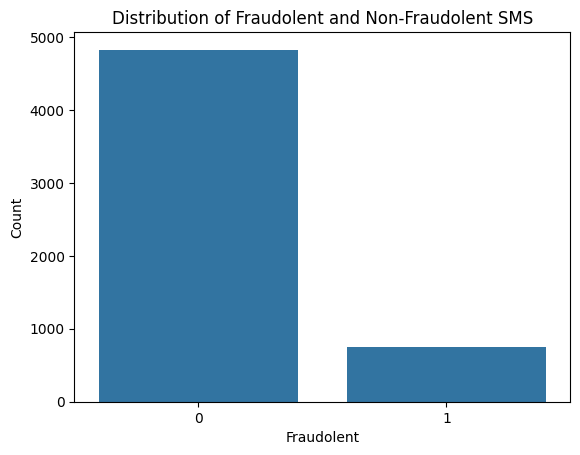

In [6]:
print("Summary Statistics:")
print(df.describe())

sns.countplot(data=df, x="Fraudolent")
plt.title('Distribution of Fraudolent and Non-Fraudolent SMS')
plt.xlabel('Fraudolent')
plt.ylabel('Count')
plt.show()


<h3 id="section4">Data Preprocessing</h3>

In [7]:
# splitting the dataframe into training set and test set
# X = df["SMS test"]
# y = df["Fraudolent"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=
#                                                     0.25, random_state=1)
TRAIN_TEST_SPLIT = 3714

#training dataset
train_text=df.SMS_test[:TRAIN_TEST_SPLIT]
train_sentiments=df.Fraudolent[:TRAIN_TEST_SPLIT]

#testing dataset
test_text=df.SMS_test[TRAIN_TEST_SPLIT:]
test_sentiments=df.Fraudolent[TRAIN_TEST_SPLIT:]

print(train_text.shape, train_sentiments.shape)
print(test_text.shape, test_sentiments.shape)


(3714,) (3714,)
(1858,) (1858,)


In [ ]:
# handle missing values


In [14]:
# normalizing text
nltk.download('stopwords')

# tokenizing text
tokenizer=ToktokTokenizer()

# setting english stopwords
stopword_list=nltk.corpus.stopwords.words('english')

# defining function to remove html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# applying denoise-function to text column
df['SMS_test']=df['SMS_test'].apply(strip_html)

# ############### => look into this - either use this block or what comes after really not sure which one is better for normalization
# removing punctuation and special characters from the text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text
# function to normalize text
def normalize_text(text):
    text = strip_html(text)
    tokens = tokenizer.tokenize(clean_text(text))
    tokens = [token for token in tokens if token not in stopword_list]
    return tokens
normalized_data = []
for i in range(len(df)):
    normalized_data.append(normalize_text(df['SMS_test'][i
                                                     ]))
print("Normalization complete!")
print(normalized_data)
#################

# defining function to remove square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# applying denoise-function to text column
df['SMS_test']=df['SMS_test'].apply(remove_between_square_brackets)

# defining function to remove noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

# applying denoise-function to text column
df['SMS_test']=df['SMS_test'].apply(denoise_text)

# defining function to remove special characters
def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# applying special-characters-function to text column
df['SMS_test']=df['SMS_test'].apply(remove_special_characters)

# defining function to stemm the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

# applying stemming-function to text column
df['SMS_test']=df['SMS_test'].apply(simple_stemmer)

# setting stopwords to english
stop=set(stopwords.words('english'))
print(stop)

# defining function to remove stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# applying -stopword-function to text column
df['SMS_test']=df['SMS_test'].apply(remove_stopwords)

print(df['SMS_test'])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arthurbirnstiel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Normalization complete!
[['squeeeeez', 'thi', 'christma', 'hug', 'u', 'lik', 'frndshp', 'den', 'hug', 'back', 'u', 'get', 'u', 'r', 'cute', 'u', 'r', 'luvd', 'u', 'r', 'lucki', 'none', 'peopl', 'hate', 'u'], ['also', 'ive', 'sorta', 'blown', 'coupl', 'time', 'recent', 'id', 'rather', 'text', 'blue', 'look', 'weed'], ['mmm', 'better', 'got', 'roast', 'id', 'b', 'better', 'drink', 'good', 'indian'], ['mm', 'kanji', 'dont', 'eat', 'anyth', 'heavi', 'ok'], ['ring', 'come', 'guy', 'costum', 'gift', 'futur', 'yowif', 'hint', 'hint'], ['sari', 'need', 'tim', 'bollox', 'hurt', 'lot', 'tol'], ['love', 'isnt', 'deci', 'feel', 'could', 'decid', 'love', 'life', 'would', 'much', 'simpler', 'less', 'magic'], ['supervisor', 'find', 'one', 'lor', 'thk', 'hi', 'student', 'havent', 'ask', 'yet', 'tell', 'u', 'aft', 'ask'], ['dear', 'good', 'morn', 'onli'], ['im', 'chennai', 'velacheri'], ['lol', 'grr', 'mom', 'take', 'forev', 'prescript', 'pharmaci', 'like', 'minut', 'away', 'ugh'], ['valentin', 'huh', 

In [26]:
# normalizing training text
norm_train_text=df.SMS_test[:TRAIN_TEST_SPLIT]
norm_train_text[0]

# Normalizing testing text
norm_test_text=df.SMS_test[TRAIN_TEST_SPLIT:]
norm_test_text[4000]



'hurri ive weeddefici like three day'

In [25]:
#Count vectorizer for BoW
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=True,ngram_range=(1,3))

#transforming the training text
cv_train_text=cv.fit_transform(norm_train_text)

#transforming the testing text
cv_test_text=cv.transform(norm_test_text)

print('BOW_cv_train:', cv_train_text.shape)
print('BOW_cv_test:', cv_test_text.shape)
print(cv_train_text.__class__)


BOW_cv_train: (3714, 51138)
BOW_cv_test: (1858, 51138)
<class 'scipy.sparse._csr.csr_matrix'>


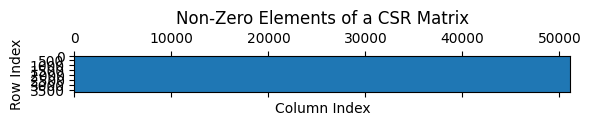

  (0, 40582)	1
  (0, 43134)	1
  (0, 8953)	1
  (0, 21635)	1
  (0, 25425)	1
  (0, 16538)	1
  (0, 11817)	1
  (0, 5031)	1
  (0, 16977)	1
  (0, 10861)	1
  (0, 26925)	1
  (0, 26802)	1
  (0, 30913)	1
  (0, 33158)	1
  (0, 20018)	1
  (0, 40583)	1
  (0, 43159)	1
  (0, 8959)	1
  (0, 21640)	1
  (0, 25426)	1
  (0, 16539)	1
  (0, 11825)	1
  (0, 21636)	1
  (0, 5066)	1
  (0, 17079)	1
  :	:
  (3711, 39930)	1
  (3711, 7684)	1
  (3711, 46561)	1
  (3711, 19316)	1
  (3711, 46562)	1
  (3711, 19317)	1
  (3711, 46563)	1
  (3712, 25429)	1
  (3712, 22921)	1
  (3712, 22926)	1
  (3713, 12651)	1
  (3713, 10351)	1
  (3713, 4344)	1
  (3713, 24111)	1
  (3713, 14519)	1
  (3713, 12739)	1
  (3713, 8706)	1
  (3713, 10352)	1
  (3713, 24176)	1
  (3713, 14522)	1
  (3713, 4382)	1
  (3713, 12747)	1
  (3713, 24177)	1
  (3713, 14523)	1
  (3713, 10354)	1


In [46]:
# Visualize the sparse matrix
plt.spy(cv_train_text, markersize=5)
plt.title('Non-Zero Elements of a CSR Matrix')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()
print(cv_train_text)


In [35]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))

#transforming training text
tv_train_text=tv.fit_transform(norm_train_text)

#transforming testing text
tv_test_text=tv.transform(norm_test_text)

print('Tfidf_train:', tv_train_text.shape)
print('Tfidf_test:', tv_test_text.shape)

print(df.head())


Tfidf_train: (3714, 51138)
Tfidf_test: (1858, 51138)
   Fraudolent                                           SMS_test       ID  \
0           0  squeeeeez thi christma hug u lik frndshp den h...  1EWYRBL   
1           0  also ive sorta blown coupl time recent id rath...  ZY4PDK7   
2           0  mmm better got roast id b better drink 2 good ...  KLUX2C6   
3           0                   mm kanji dont eat anyth heavi ok  955HXJ0   
4           0    ring come guy costum gift futur yowif hint hint  00Q6EUC   

  Date and Time  
0    2017-12-02  
1    2018-03-23  
2    2016-10-29  
3    2018-04-12  
4    2016-08-01  


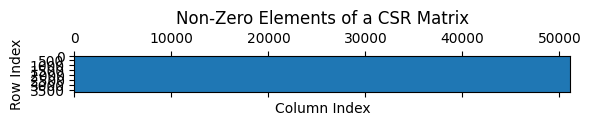

  (0, 30921)	0.15589282278925493
  (0, 26818)	0.15589282278925493
  (0, 26927)	0.15589282278925493
  (0, 10865)	0.15589282278925493
  (0, 17080)	0.15589282278925493
  (0, 5067)	0.15589282278925493
  (0, 21637)	0.15589282278925493
  (0, 11826)	0.15589282278925493
  (0, 16540)	0.15589282278925493
  (0, 25427)	0.15589282278925493
  (0, 21641)	0.15589282278925493
  (0, 8960)	0.15589282278925493
  (0, 43160)	0.15589282278925493
  (0, 40584)	0.15589282278925493
  (0, 33170)	0.15589282278925493
  (0, 30920)	0.15589282278925493
  (0, 26817)	0.15589282278925493
  (0, 26926)	0.15589282278925493
  (0, 10864)	0.15589282278925493
  (0, 17079)	0.15589282278925493
  (0, 5066)	0.1484799931576842
  (0, 21636)	0.15589282278925493
  (0, 11825)	0.15589282278925493
  (0, 16539)	0.15589282278925493
  (0, 25426)	0.15589282278925493
  :	:
  (3711, 7684)	0.3131430550579106
  (3711, 39930)	0.3131430550579106
  (3711, 7683)	0.3131430550579106
  (3711, 22679)	0.23811422747896044
  (3711, 39907)	0.2054448027853962

In [37]:
# Visualize the sparse matrix
plt.spy(tv_train_text, markersize=5)
plt.title('Non-Zero Elements of a CSR Matrix')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()
print(tv_train_text)


In [ ]:
#labeling the sentiment data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(df['Fraudolent'])
print(sentiment_data.shape)


<h3 id="section5">Models</h3>

In [49]:
# keeping track of all confusion matrices
conf_matrices = {}


<h4>Model 1: Logisitc Regression</h4>

In [ ]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)


Training with Bag of words

In [59]:
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_text,train_sentiments)

#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_text)


Testing with Bag of Words

lr_bow_score : 0.9628632938643703
              precision    recall  f1-score   support

    Positive       0.96      1.00      0.98      1606
    Negative       1.00      0.73      0.84       252

    accuracy                           0.96      1858
   macro avg       0.98      0.86      0.91      1858
weighted avg       0.96      0.96      0.96      1858



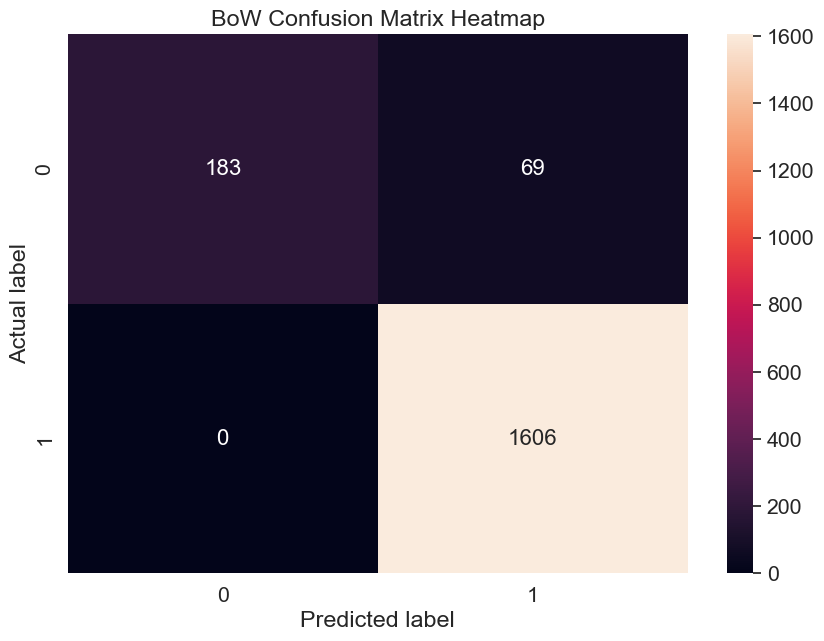

In [60]:
# Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

# Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

# confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
conf_matrices["lr_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


Training with TF-IDF

In [61]:
# Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_text,train_sentiments)

# Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_text)


Testing with TF-IDF

lr_tfidf_score : 0.926264800861141
              precision    recall  f1-score   support

    Positive       0.92      1.00      0.96      1606
    Negative       0.98      0.47      0.63       252

    accuracy                           0.93      1858
   macro avg       0.95      0.73      0.80      1858
weighted avg       0.93      0.93      0.91      1858



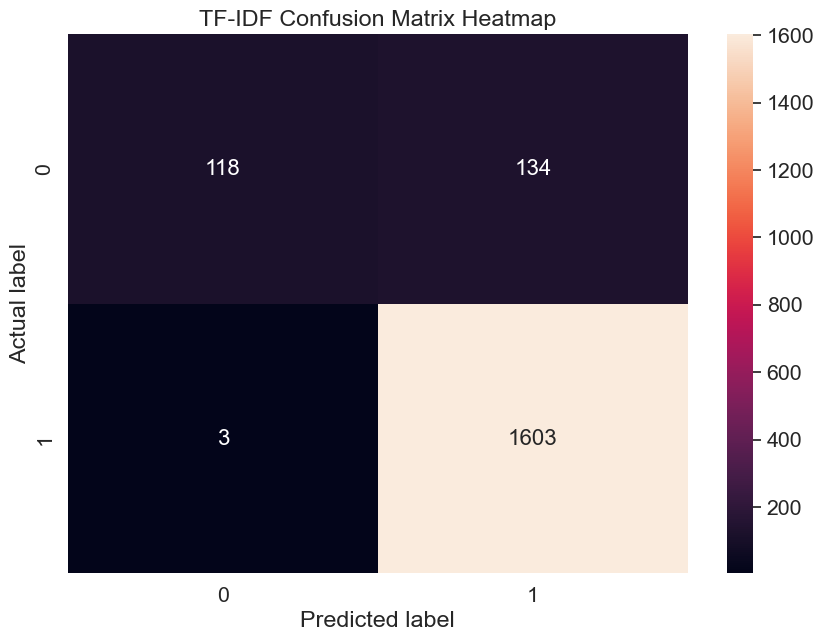

In [62]:
# Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

# Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
conf_matrices["lr_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


<h4>Model 2: Linear and Kernel SVM</h4>

<h5>Linear SVM</h5>

In [77]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)


Training with Bag of Words

In [78]:
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_text,train_sentiments)

#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_text)


Testing with Bag of Words

svm_bow_score : 0.9714747039827771
              precision    recall  f1-score   support

    Positive       0.97      1.00      0.98      1606
    Negative       1.00      0.79      0.88       252

    accuracy                           0.97      1858
   macro avg       0.98      0.89      0.93      1858
weighted avg       0.97      0.97      0.97      1858



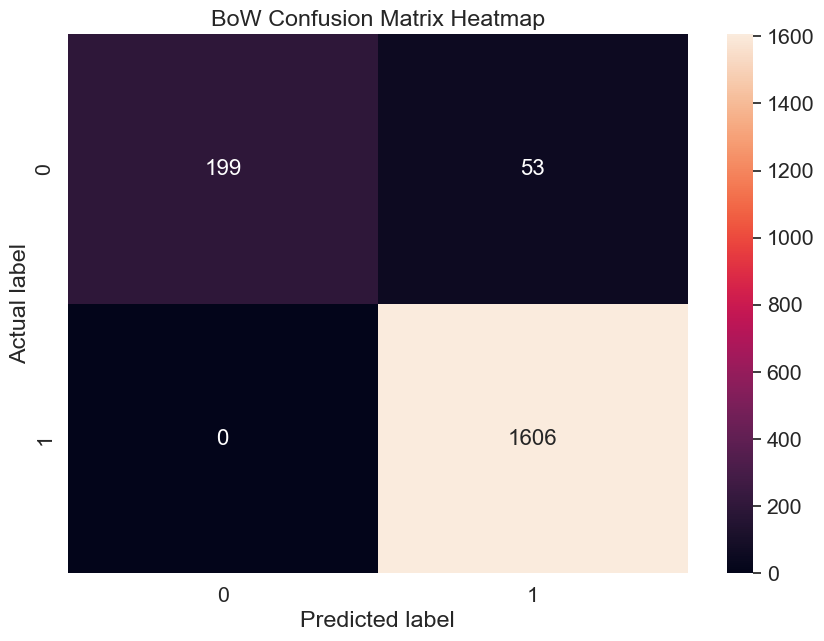

In [79]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)

#Classification report for bag of words
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)

#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
conf_matrices["svm_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


Training with TF-IDF

In [80]:
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_text,train_sentiments)

#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_text)


Testing with TF_IDF

svm_tfidf_score : 0.9779332615715823
              precision    recall  f1-score   support

    Positive       0.98      0.99      0.99      1606
    Negative       0.95      0.88      0.92       252

    accuracy                           0.98      1858
   macro avg       0.97      0.94      0.95      1858
weighted avg       0.98      0.98      0.98      1858



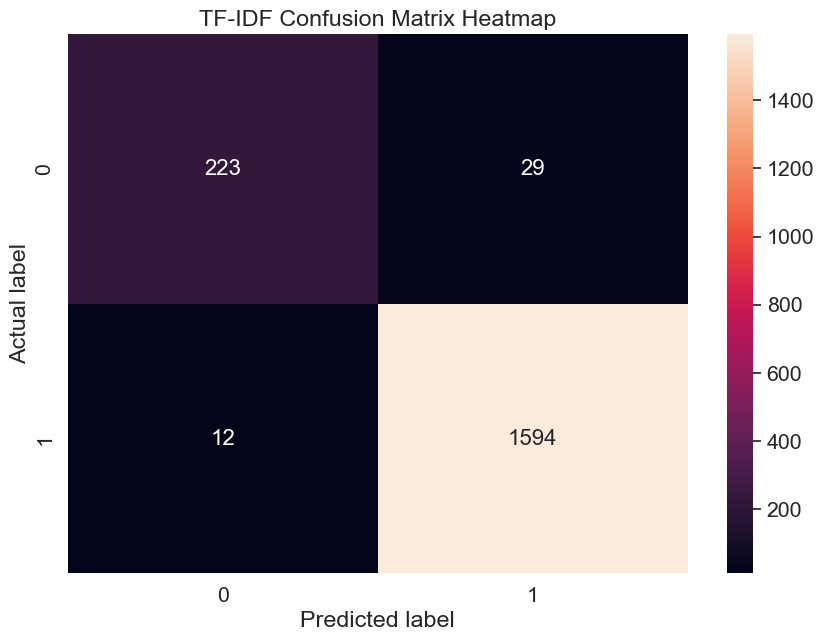

In [81]:
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
conf_matrices["svm_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


<h5>Kernel SVM</h5>

training with Bag of Words

In [ ]:
# how to train a kernel svm for a dataframe with python?


training with TF-IDF

<h4>Model 3: Multinomial NB</h4>

In [82]:
#training the model
mnb=MultinomialNB()


Training with Bag of Words

In [83]:
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_text,train_sentiments)

#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_text)


mnb_bow_score : 0.9757804090419806
              precision    recall  f1-score   support

    Positive       0.98      1.00      0.99      1606
    Negative       0.96      0.85      0.91       252

    accuracy                           0.98      1858
   macro avg       0.97      0.92      0.95      1858
weighted avg       0.98      0.98      0.98      1858



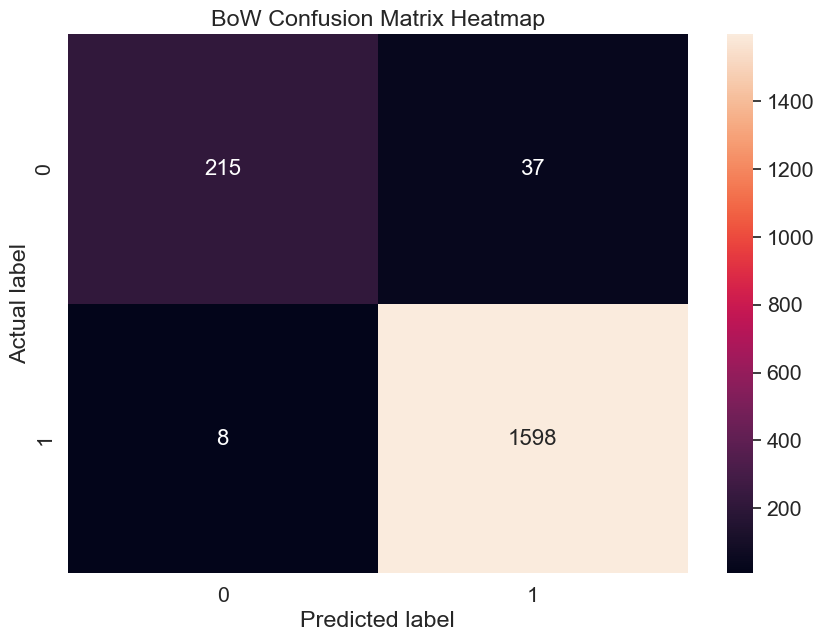

In [84]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

#Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)

#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
conf_matrices["mnb_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


Training with TF-IDF

In [85]:
# fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_text,train_sentiments)

#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_text)


Testing with TF-IDF

mnb_tfidf_score : 0.9311087190527448
              precision    recall  f1-score   support

    Positive       0.93      1.00      0.96      1606
    Negative       1.00      0.49      0.66       252

    accuracy                           0.93      1858
   macro avg       0.96      0.75      0.81      1858
weighted avg       0.94      0.93      0.92      1858



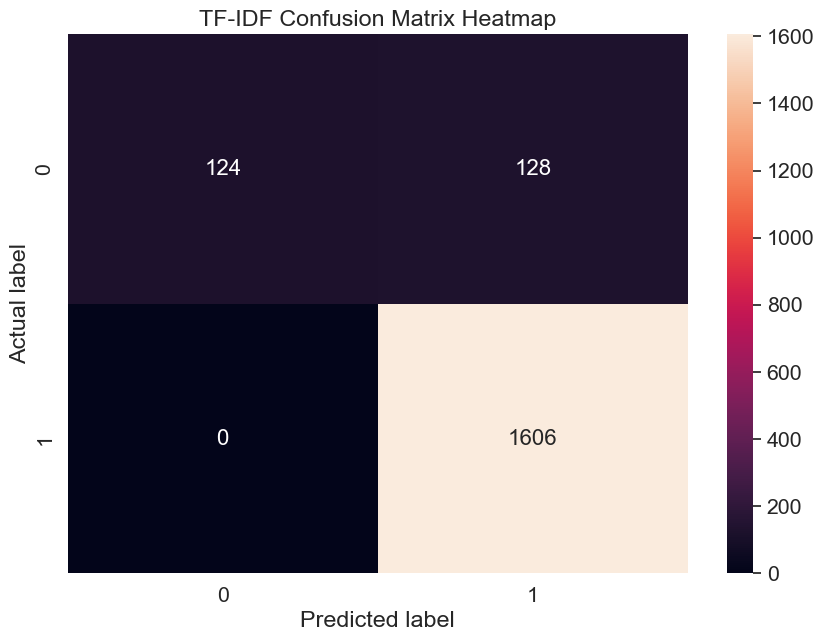

In [86]:
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)


#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)


#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
conf_matrices["mnb_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


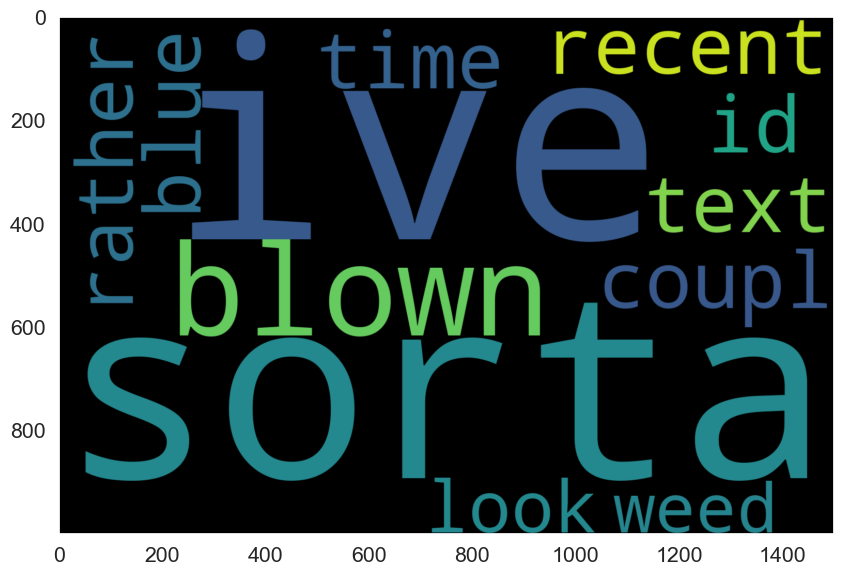

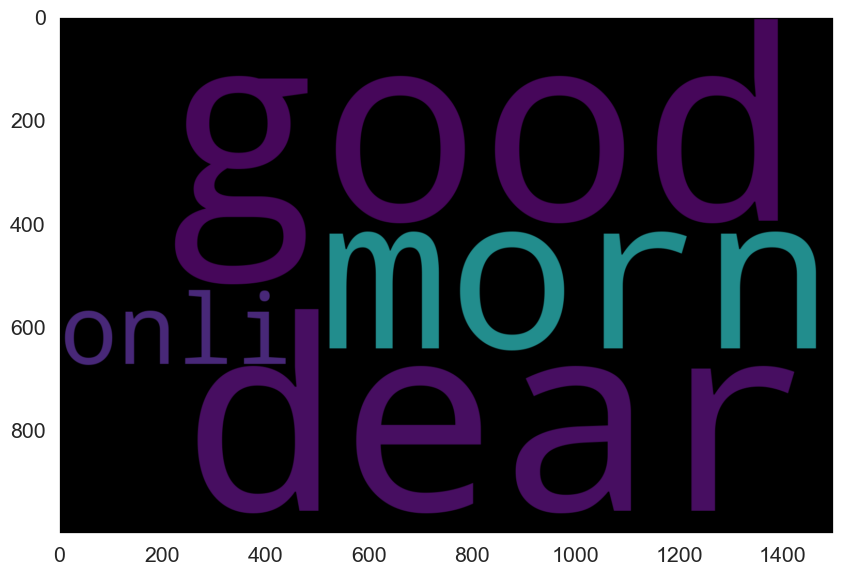

In [87]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_text[1]
WC=WordCloud(width=1500,height=1000,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.grid(False)
plt.show()

#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_text[8]
WC=WordCloud(width=1500,height=1000,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.grid(False)
plt.show()


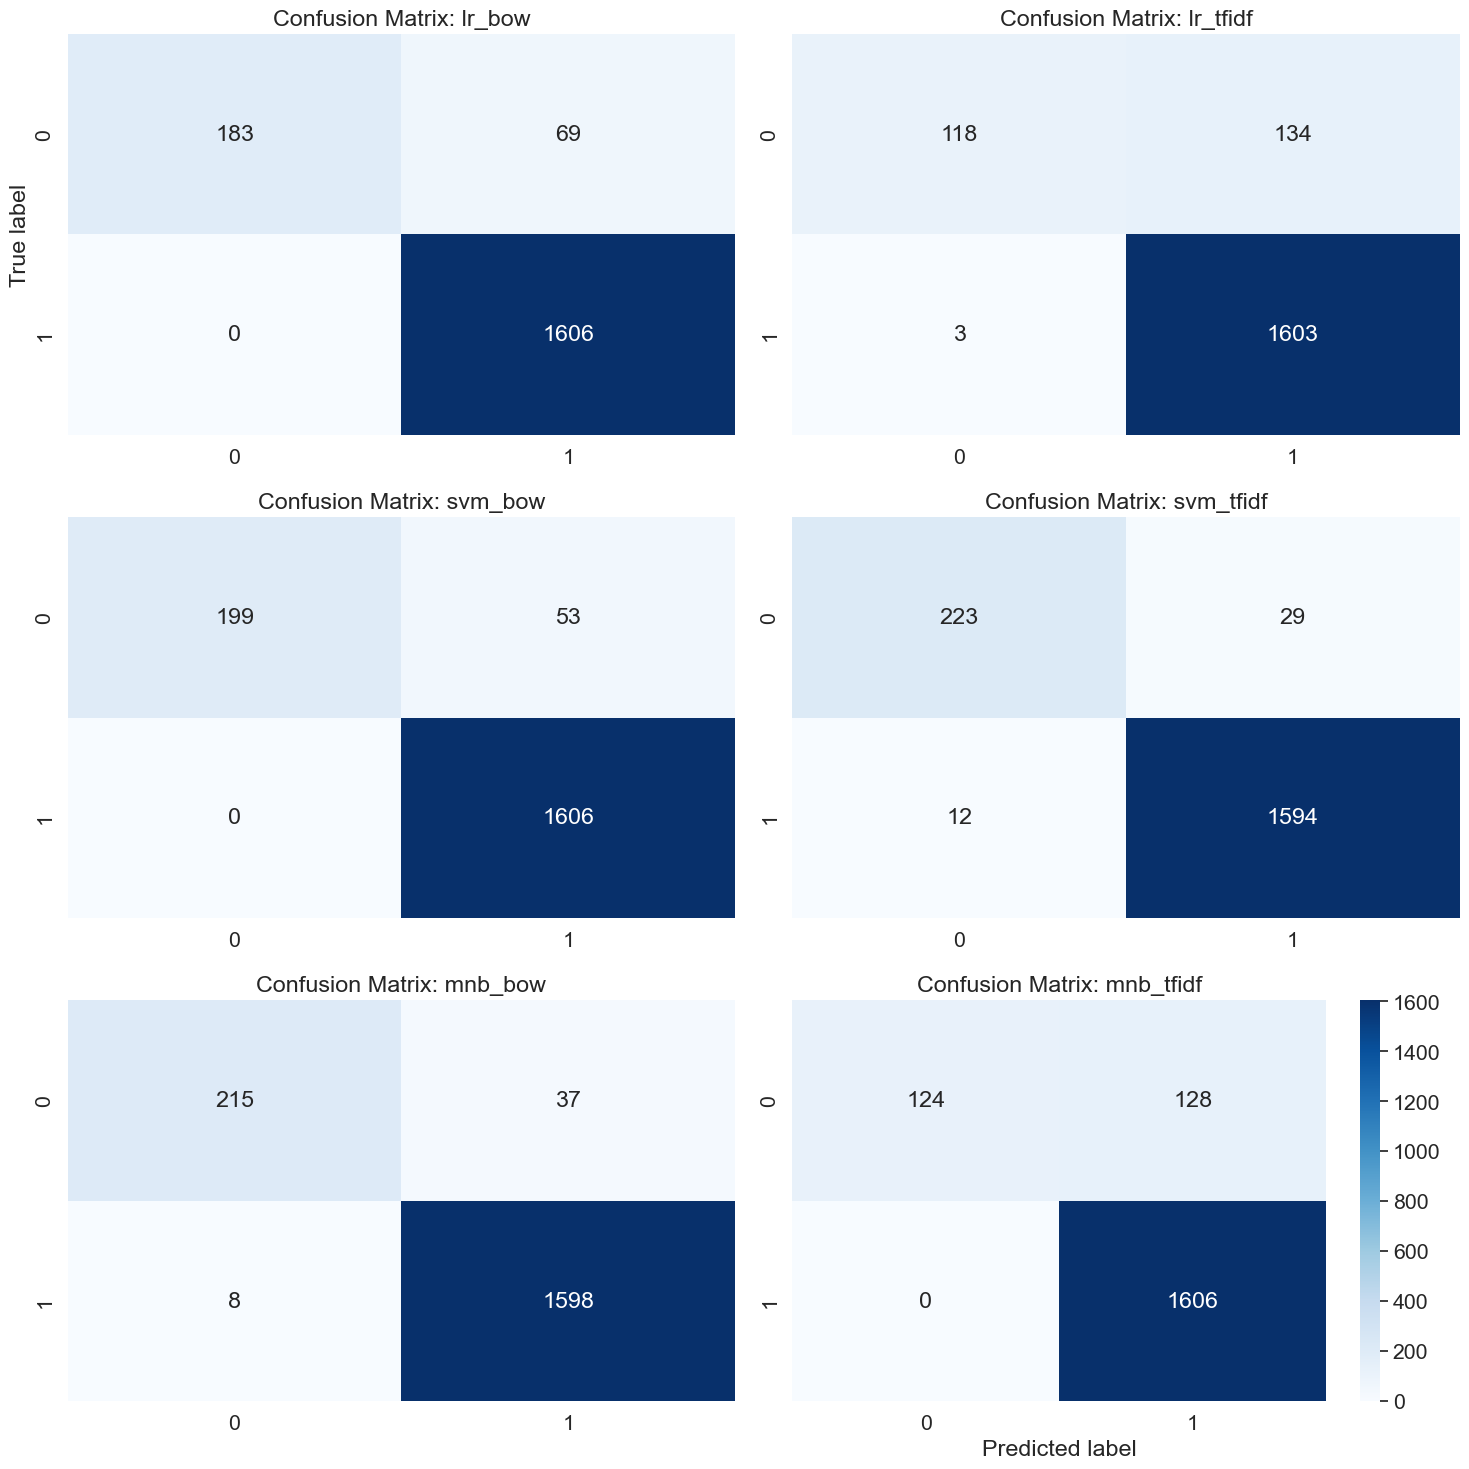

In [88]:
def plot_confusion_matrix(ax, conf_matrix, classifier_name, position):
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=(position == 'last'))
    ax.set_title(f'Confusion Matrix: {classifier_name}')
    if position in ['first', 'middle']:
        ax.set_xlabel('')  # Remove x-label
    else:
        ax.set_xlabel('Predicted label')
    if position in ['middle', 'last']:
        ax.set_ylabel('')  # Remove y-label
    else:
        ax.set_ylabel('True label')

# Determine the number of classifiers (and hence, the number of subplots required)
num_classifiers = len(conf_matrices)

# Create subplots
fig, axes = plt.subplots(num_classifiers // 2, 2, figsize=(15, 5 * (num_classifiers // 2)))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
positions = ['first'] + ['middle'] * (num_classifiers - 2) + ['last']
for ax, (classifier_name, conf_matrix), position in zip(axes, conf_matrices.items(), positions):
    plot_confusion_matrix(ax, conf_matrix, classifier_name, position)

plt.tight_layout()
plt.show()


<h3 id="section6">Testing</h3>

In [ ]:
# alt run tests in seperate file?
